In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
# Get the name of all 100 clips into a list

clip_path = "/Users/f004p74/Documents/dartmouth/projects/NNDb/movie_clips/"
clip_dir = os.listdir(clip_path)
movie_list = [x for x in clip_dir if '.' not in x] #generates a list of all 10 movies
clip_list = []

zip_name, zip_start, zip_stop = [],[],[]


for movie in movie_list:
    clips = [x for x in os.listdir(clip_path+movie) if 'mp4' in x]
    
    for clip in clips:
        name = clip.split('.')[0]
        start = name.split('_')[1]
        stop = name.split('_')[2]
        clip_list.append(name)

        zip_name.append(name)
        zip_start.append(start)
        zip_stop.append(stop)


In [ ]:
clip_dict = dict(zip(zip_name, zip(zip_start, zip_stop)))

In [ ]:
# Get a list of all the participant .nii files

#img_path = "/Users/f004p74/Documents/dartmouth/projects/NNDb/data_fmri/"
derivative_path = "/Users/f004p74/Documents/dartmouth/projects/NNDb/derivatives/"
#func_data = os.listdir(img_path)
#sub_data = [x for x in func_data if ('sub-') in x] #grab all the subject IDs for easy filtering

# make a sub-directory for each subject's trimmed nii files -- DONE
# for sub in sub_data:
#     sub_id = sub.split('_')[0]
#     os.mkdir(out_path+sub_id)

#len(sub_data) # 86


For each subject, we want to trim out separate files that correspond to the moments that they watched the social interaction clips we selected for further analysis. We add 4 seconds to the beginning and end of the fMRI timeseries to account for the hemodynamic response. 

In [ ]:
#DONE

# for movie in movie_list:
#     sub_clips = [x for x in clip_list if movie in x]
#     sub_subs =  [x for x in sub_data if movie in x]

#     for sub in sub_subs:
#         sub_id = sub.split('_')[0]
#         img = nb.load(img_path+sub)
#         for clip in sub_clips:
#             start = int(clip_dict[clip][0]) - 4
#             stop = int(clip_dict[clip][1]) + 4
#             clip_slice = img.slicer[:,:,:,start:stop]

#             fname = sub_id+"_"+movie+"_"+str(start)+"_"+str(stop)
#             nb.save(clip_slice, out_path+sub_id+os.sep+fname+".nii.gz")


## Apply schaefer atlas to clipped nii files

In [ ]:
import nibabel as nb
import nilearn
from nilearn import datasets
import nilearn.image as image
from nilearn.maskers import NiftiMasker

In [ ]:
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
                                                    data_dir=None, base_url=None, resume=True, verbose=1)
'''
From the documentation:
The list of labels does not contain ‘Background’ by default. 
To have proper indexing, you should either manually add ‘Background’ to the list of labels:
'''

schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

In [ ]:
len(schaefer_atlas.labels)

In [ ]:
sub_list = os.listdir(derivative_path)
sub_list = [x for x in sub_list if 'sub' in x] #remove hidden files

print(sub_list[0:4], len(sub_list))

In [ ]:
#make a sub-directory for each subject's parcel  matrices--DONE

# for sub in sub_list:
#     try:
#         os.mkdir(derivative_path+sub+os.sep+"parcel_matrix")
#     except:
#         continue

In [ ]:
len(schaefer_atlas.labels)

In [ ]:
# holding all 400 parcel masks in memory; takes apprx 2m13s
mask_list = []

for p in range(1,402): #402

    try:
        parcel = nilearn.image.new_img_like(schaefer_atlas.maps, nilearn.image.get_data(schaefer_atlas.maps) == p) #hold the parcel masks in memory 
        masker = NiftiMasker() 

        parcel_mask = masker.fit(parcel)
        mask_list.append(parcel_mask)
    
    except: 
        print("out of range, p=", p)
        continue

In [ ]:
for s in sub_list[0:1]: #20 min per subject
    print("Starting with subject: ", s)
    sub_clips = os.listdir(derivative_path+s)
    sub_clips = [x for x in sub_clips if 'sub' in x]
    sub_clips.sort() # super important, it has to be in ascending order. 

    for c in sub_clips[1:]: #2m 13s per clip
        clip_slice = nb.load(derivative_path+s+os.sep+c)
        clip_avg = image.mean_img(clip_slice)

        clip_name = c.replace('.', '_')
        clip_name = clip_name.split('_')[1:4]
        clip_name = "_".join(clip_name)

        data_list = []

        for ix,mask in enumerate(mask_list):
            try:
                roi_data = mask.transform_single_imgs(clip_avg)
                data_list.append(roi_data[0])
            except:
                print("index: ", ix)
                continue

        df = pd.DataFrame(data_list)
        df.to_csv(derivative_path+s+os.sep+"clip_voxels/"+str(clip_name)+".csv", index=False)


# <font color='deeppink'>Creating Similartiy Matrices</font>

In [ ]:
import os
import pandas as pd
from sklearn.metrics import pairwise_distances

In [ ]:
derivatives = "/Users/f004p74/Documents/dartmouth/projects/NNDb/derivatives/"

sub_list = os.listdir(derivatives)
sub_list = [x for x in sub_list if 'sub' in x] #remove hidden files

<font color='deeppink'>Create a 10x10 similarity matrix: </font> for each parcel, I want to create a similarity matrix among all the 10 clips the participant watched.

In [ ]:
for s in sub_list:
    print("correlating: ", s)
    spath = derivatives+s+'/clip_voxels/'
    parcel_list = [x for x in  os.listdir(spath) if '.csv' in x]

    df_list = [pd.read_csv(spath+x) for x in parcel_list]

    for i in range(len(df_list[0])): #0,1,...400 for each row

        mat = pd.DataFrame()

        for ix, df in enumerate(df_list): # go into each df 
            voxels = df.iloc[i]
            mat[parcel_list[int(ix)]] = voxels

        mat.dropna(inplace=True)
        distance_matrix = pd.DataFrame(pairwise_distances(mat.T, metric='correlation'))

        distance_matrix.to_csv(derivatives+s+'/parcel_matrix/'+str(i)+"_correlation.csv", index=False, header=False)


<font color='deeppink'>Import the 100x100 behavioral distance matrix.</font>

In [8]:
import pandas as pd
import numpy as np
import nilearn
import statsmodels.api as sm
from nilearn.connectome import ConnectivityMeasure

In [9]:
derivatives = "/Users/f004p74/Documents/dartmouth/projects/NNDb/derivatives/"

sub_list = os.listdir(derivatives)
sub_list = [x for x in sub_list if 'sub' in x] #remove hidden files

In [10]:
iv_list = []

for x in os.listdir(derivatives+"behavioral_matrices"):
    if '.csv' in x:
        print(x)
        df = pd.read_csv(derivatives+"behavioral_matrices/"+x)
        iv_list.append(df)
    else:
        continue

conflict_distance_matrix.csv
watched_distance_matrix.csv
count_people_distance_matrix.csv
violence_distance_matrix.csv
count_interactions_distance_matrix.csv
feeling_distance_matrix.csv
tension_distance_matrix.csv
social_distance_matrix.csv


First, check if there is co-linearity between the IV's

In [ ]:
# code for co-linearity

### <font color='hotpink'> next, model the DVs matrices.</font>

In [62]:
for s in sub_list[63:64]:
    print(s)
    spath = derivatives+s
    smovielist = [x for x in os.listdir(spath) if 'sub' in x]
    smovie = smovielist[0].split('_')[1]

    parcel_list = [x for x in  os.listdir(spath+'/parcel_matrix/') if 'correlation' in x]
    parcel_names = [x.split('_')[0] for x in parcel_list]

    results_df = pd.DataFrame(columns=[['constant','conflict', 'watched', 'npeople', 'violence', 'ninteractions', 'feeling', 'tension', 'issocial']])

    for p in parcel_list:
        parcel_df = pd.read_csv(spath+'/parcel_matrix/'+p, header=None)
        y = nilearn.connectome.sym_matrix_to_vec(np.array(parcel_df), discard_diagonal=True) # lower triangle

        all_iv = np.empty((45,8))
        
        for i in range(len(iv_list)):
            df = iv_list[i]
            filtered_df = df[(df.movie == smovie)]
            col = [str(x) for x in list(filtered_df.index)]
            
            x_100 = filtered_df.drop(['movieID','movie'], axis=1)
            x = x_100[col]
            x_lower = nilearn.connectome.sym_matrix_to_vec(np.array(x), discard_diagonal=True) # lower triangle

            all_iv[:,i] = x_lower
        
        all_iv = sm.add_constant(all_iv)
        regression = sm.OLS(y,all_iv)
        results = regression.fit()

        results_df.loc[len(results_df)] = results.params
    
    results_df['subject'] = s
    results_df['movie'] = smovie
    results_df['parcel'] = parcel_names
    

    results_df.to_csv(spath+'/results.csv')

sub-11


### <font color='deeppink'> Intercept-only mixed effects model</font>
First, we need to re-organize the data so that we model by parcel

In [1]:
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

In [54]:
derivatives = "/Users/f004p74/Documents/dartmouth/projects/NNDb/derivatives/"

sub_list = os.listdir(derivatives)
sub_list = [x for x in sub_list if 'sub' in x] #remove hidden files

In [75]:
bof = []

for s in sub_list:
    spath = derivatives+s
    bof.append(pd.read_csv(spath+'/results.csv'))

results = pd.concat(bof)
results.reset_index(inplace=True, drop=True)
results.drop(['Unnamed: 0'],inplace=True, axis=1)
results.to_csv(derivatives+"/complete_betas.csv")

In [93]:
#takes 10 minutes!
out = pd.DataFrame(columns=[['conflict', 'watched', 'npeople', 'violence', 'ninteractions', 'feeling', 'tension', 'issocial']])

for i in range(400):
    parcel = results.loc[results.parcel == i]

    model1 = smf.mixedlm('conflict ~ 1', parcel, groups=parcel["movie"])
    model2 = smf.mixedlm('watched ~ 1', parcel, groups=parcel["movie"])
    model3 = smf.mixedlm('npeople ~ 1', parcel, groups=parcel["movie"])
    model4 = smf.mixedlm('violence ~ 1', parcel, groups=parcel["movie"])
    model5 = smf.mixedlm('ninteractions ~ 1', parcel, groups=parcel["movie"])
    model6 = smf.mixedlm('feeling ~ 1', parcel, groups=parcel["movie"])
    model7 = smf.mixedlm('tension ~ 1', parcel, groups=parcel["movie"])
    model8 = smf.mixedlm('issocial ~ 1', parcel, groups=parcel["movie"])

    mdf1 = model1.fit()
    mdf2 = model2.fit()
    mdf3 = model3.fit()
    mdf4 = model4.fit()
    mdf5 = model5.fit()
    mdf6 = model6.fit()
    mdf7 = model7.fit()
    mdf8 = model8.fit()

    params = [mdf1.params[0], mdf2.params[0], mdf3.params[0], mdf4.params[0],
     mdf5.params[0], mdf6.params[0], mdf7.params[0], mdf8.params[0]]

    out.loc[len(out)] = params

    

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.

In [95]:
out.to_csv(derivatives+'/parcel_model_outs.csv')

In [96]:
import seaborn as sns

<Axes: xlabel='None'>

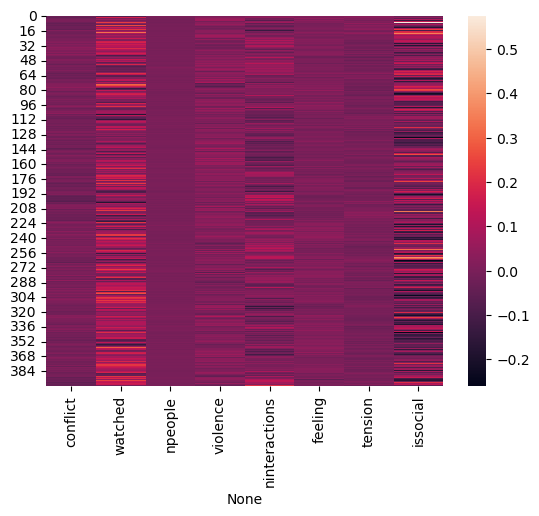

In [99]:
sns.heatmap(out)